### Functions:

Note: The images displayed are randomly sampled (10 from training set of each category) to play around with / visualise what is happening.

*print_category_names()* -- print names of categories in dataset

*show_category_images(category, img_type, num)* -- show 'num' images of a category

*show_category_average(category, img_type, num)* -- show average over 'num' images of a category

*get_hog(category, img_type, num)* -- get HOG features for images of a category

*get_similarity(category_1, category_2, img_type)* -- get similarity between two prototypical category representations

*get_similarity(category_1, img_type_1, category_2, img_type_2)* -- get similarity between prototypical category representations of different types i.e., photo 'cat' vs. sketch 'dog'

*get_similarity(category_1, img_type)* -- get elementwise similarity of individual members to the prototypical represenation (leaving that one out)


In [43]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

path = os.getcwd(); cat_path = path + '/data/sketchy/ecategories/'
# path to random experimental 10 images for each category
categories = os.listdir(cat_path)

# shows the different categories in the Sketchy dataset (categories vary for different datasets)
def print_category_names():
    print 'Length: ' + str(len(categories))
    print sorted(set(categories))

# show 'num' 'img_type' images for a category 'category' 
# e.g., show_category_images('cat', 'sketch', 5) or show_category_images('cat', 'photo', 10)
def show_category_images(category, img_type, num):
    assert num < 11
    assert os.path.isdir(cat_path + category)
    f = open(cat_path + category + '/' + img_type + '/filenames.txt')
    fnames = [line.strip() for line in f.readlines()[1:]]
    for fname in fnames[:num]:
        fpath = path + '/data/sketchy/efigs/' + fname
        if os.path.isfile(fpath) is False: continue
        img = Image.open(fpath)
        print 'category: ' + str(category)
        plt.imshow(img); plt.show()
        
# show average averaged over 'num' images for category 'category' 
# e.g., show_category_average('dog', 'sketch', '4')
def show_category_average(category, img_type, num):
    assert num < 11
    assert os.path.isdir(cat_path + category)
    f = open(cat_path + category + '/' + img_type + '/filenames.txt')
    fnames = [line.strip() for line in f.readlines()[1:]]
    avg = np.zeros((256, 256, 3))
    for fname in fnames[:num]:
        fpath = path + '/data/sketchy/efigs/' + fname
        if os.path.isfile(fpath) is False: continue
        img = Image.open(fpath)
        avg += np.array(img).astype(np.float)
    print 'your average ' + str(category)
    plt.imshow(avg); plt.show()
    


category: airplane


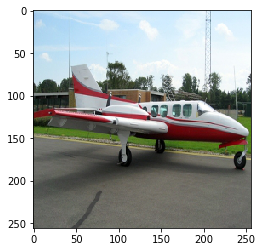

category: airplane


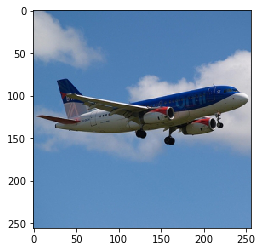

your average airplane


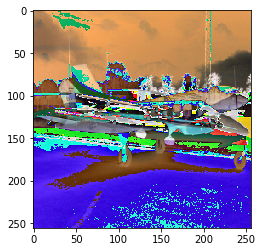

category: airplane


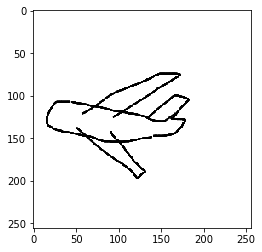

category: airplane


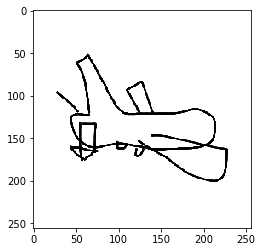

your average airplane


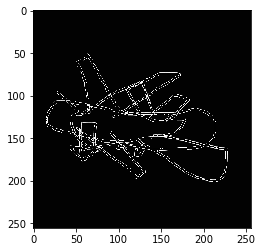

category: tiger


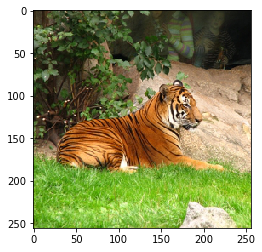

category: tiger


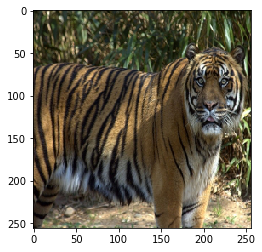

your average tiger


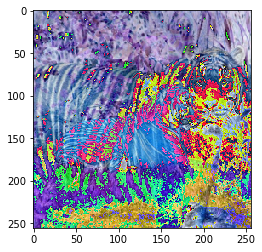

category: tiger


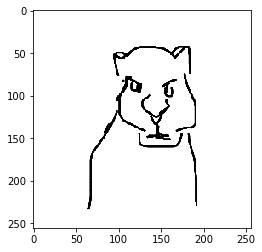

category: tiger


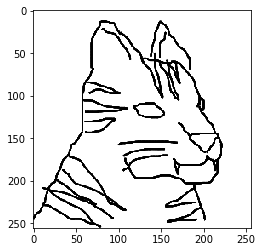

your average tiger


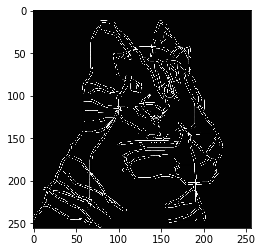

In [44]:
show_category_images('airplane', 'photo', 2)
show_category_average('airplane', 'photo', 2)
show_category_images('airplane', 'sketch', 2)
show_category_average('airplane', 'sketch', 2)

show_category_images('tiger', 'photo', 2)
show_category_average('tiger', 'photo', 2)
show_category_images('tiger', 'sketch', 2)
show_category_average('tiger', 'sketch', 2)

~ stray notes

At the end of whatever training procedure, we want a representation for each category.

Possible different representations:
    
1. Averaging pixels (representation = matrix of pixel intensity values, either RGB or gray)
2. Training a CNN with objective to predict a label (representation = last hidden layer)
3. Training an AE with objective to reconstruct image (representation = hidden layer beforere constructing)
4. Training an AE with objective to both reconstruct image and classify original/hidden representation (representation = hidden layer)
5. Training a bimodal AE with objective to reconstruct image, reconstruct text (representation = fused hidden layer of both modes)
6. Training a bimodal AE with obejctive to both reconstruct image, reconstruct text and classify fused latent represetnation (representation = hidden layer)

Take away from results i.e., if (1) works (is highly correlated with human ratings) what does this mean?
1. Raw pixels of images are enough to provide semantic information.
2. CNN features (convolving over pixels) provide semantic information.
3. Unsupervised AE features (condensing into lower dimensions i.e., getting abstract representation)
4. Semi supervised AE features (abstracting and also classifying raw pixels)
5. Bimodal AE (fusing visual and textual information and getting combined abstract representation) provides semantic information
6. Bimodal AE(get combined abstract and also classify)